# Project Introduction

Using computer vision to correctly identify what is on the image is an important feature that is used in surveilance cameras. By developing a model to detect dogs and cats, it will help with the development of pet cameras that are capable of identifying the type of animal shown in the footage. 

This project involves developing and training a deep learning model to accurately label an image as a dog or a cat. The dataset we are using is provided by Microsoft. 

We will be using a supervised learning approach by implementing two different CNN models for binary classification of images as cats or dogs.

# Goal

The goal of this project is to analyze the image, preprocess and augment, and to train two different CNN models. We execpt results to be better than blindly guessing. The performance of each CNN will be measured using accuracy and ROC. 

# Data

The data we are using in this project is publicly made available by microsoft: https://www.microsoft.com/en-us/download/details.aspx?id=54765

This public dataset contains image data of both dogs and cats. 

There are a total of 12501 dog images and 12501 cat images. 

Each image comes in different sizes and are all colored. 

In [2]:
# load packages 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
# import cv2
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

2025-04-29 08:17:53.752658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745939873.773081   65694 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745939873.781513   65694 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745939873.802012   65694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745939873.802029   65694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745939873.802030   65694 computation_placer.cc:177] computation placer alr

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

tf.random.set_seed(42)

In [4]:
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())

2.19.0
Built with CUDA: True


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU memory growth enabled")
else:
    print("No GPU found. Using CPU.")

Found 1 GPU(s)
GPU memory growth enabled


# Dataset

This dataset contains RGB images of dogs and cats. Images are not of same size. The file is in jpg format. 

There is a total of 12501 dog images and 12501 cat images.

### Load the dataset

In [6]:
cats_dir = os.path.join('./input', 'PetImages', 'Cat')
dogs_dir = os.path.join('./input', 'PetImages', 'Dog')

In [7]:
print(f"Total cat images: {len(os.listdir(cats_dir))}")
print(f"Total dog images: {len(os.listdir(dogs_dir))}")

Total cat images: 25002
Total dog images: 25002


In [8]:
filenames = []
labels = []

for filename in os.listdir(cats_dir):
    if filename.endswith('.jpg'):
        file_path = os.path.join(cats_dir, filename)
        if os.path.getsize(file_path) > 0:  # Skip corrupted files
            filenames.append(file_path)
            labels.append(0)  # 0 for cats
    
    # Add dog images
for filename in os.listdir(dogs_dir):
    if filename.endswith('.jpg'):
        file_path = os.path.join(dogs_dir, filename)
        if os.path.getsize(file_path) > 0:  # Skip corrupted files
            filenames.append(file_path)
            labels.append(1)  # 1 for dogs

In [9]:
df = pd.DataFrame({
        'filename': filenames,
        'label': labels
    })

In [10]:
df.head()

,filename,label
0,./input/PetImages/Cat/6523.jpg,0
1,./input/PetImages/Cat/4126.jpg,0
2,./input/PetImages/Cat/5431.jpg,0
3,./input/PetImages/Cat/5411.jpg,0
4,./input/PetImages/Cat/5337.jpg,0


In [11]:
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
df.head()

,filename,label
0,./input/PetImages/Cat/6173.jpg,0
1,./input/PetImages/Dog/1425.jpg,1
2,./input/PetImages/Cat/1300.jpg,0
3,./input/PetImages/Dog/5780.jpg,1
4,./input/PetImages/Dog/8259.jpg,1


# EDA

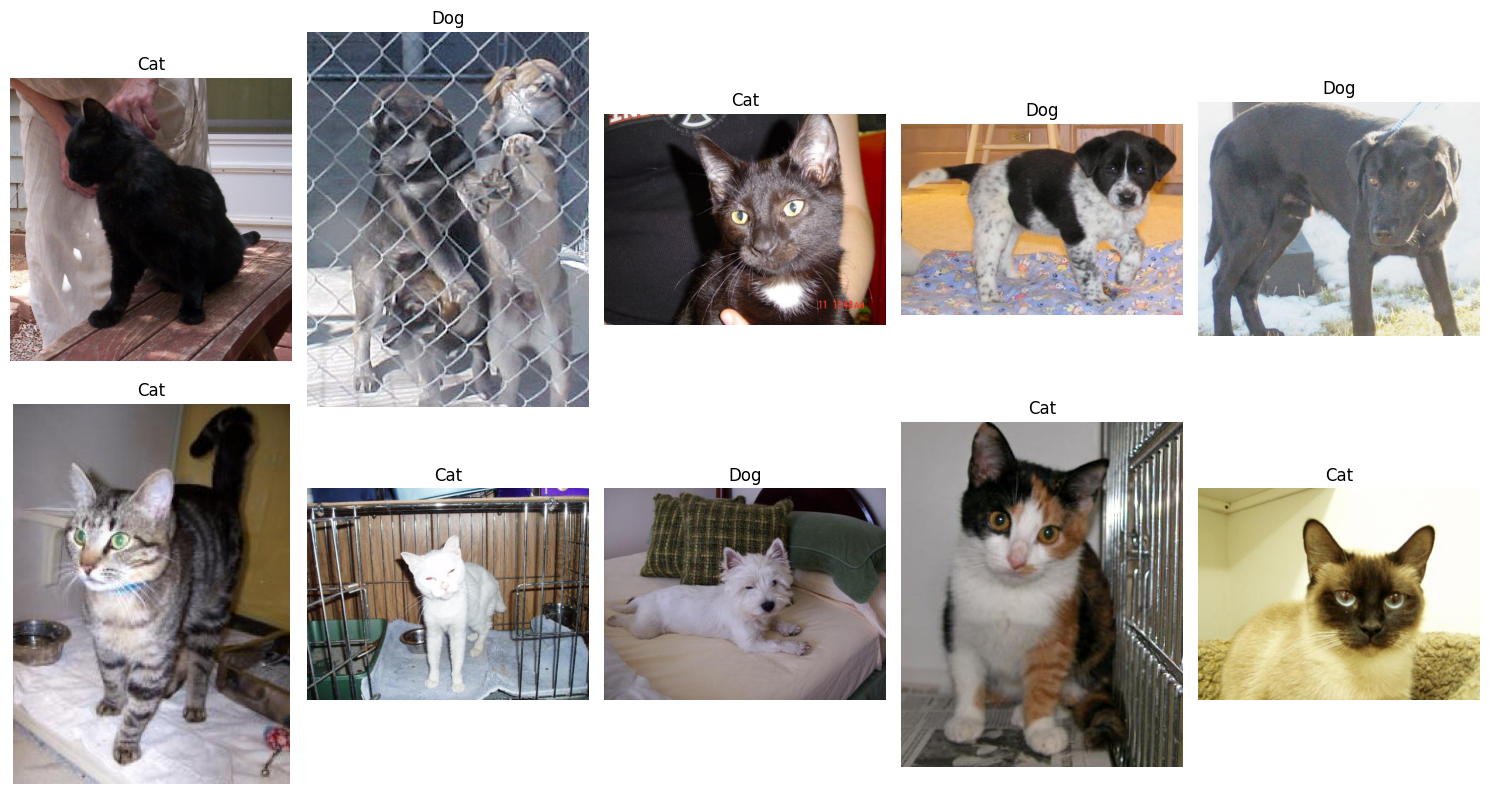

In [13]:
def display_images(df, num_images=10):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        img_path = df.iloc[i]['filename']
        img = load_img(img_path)
        
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        label = 'Cat' if df.iloc[i]['label'] == 0 else 'Dog'
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
display_images(df)

### Dataset details

Therefore, the distribution of the labels are completely balanced, making the training and evaluation of the model much simpler. 

To account for the different image sizes, we will alter the image into identical size during preprocessing. 

### Display sample images

In [14]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

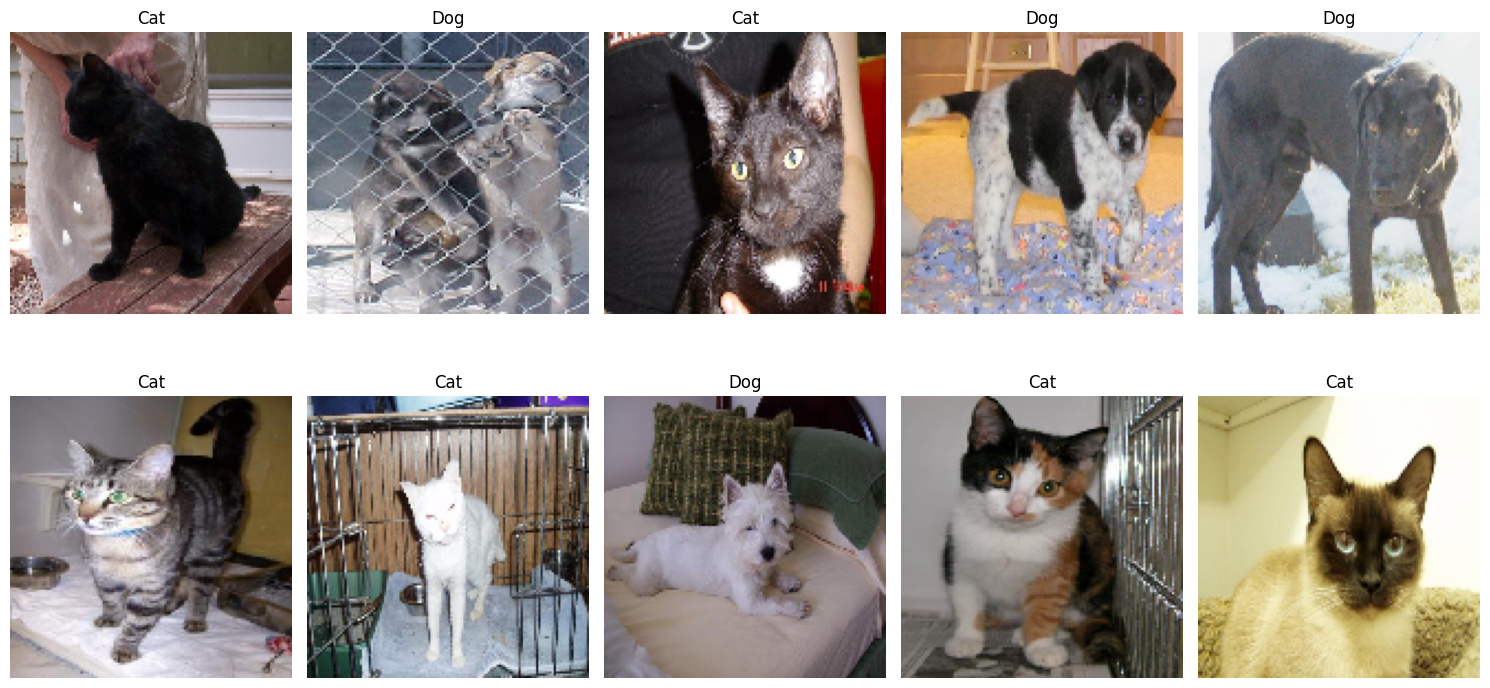

In [15]:
# Display some sample images
def display_images(df, num_images=10):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        img_path = df.iloc[i]['filename']
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        label = 'Cat' if df.iloc[i]['label'] == 0 else 'Dog'
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
display_images(df)

### Check the distribution of labels

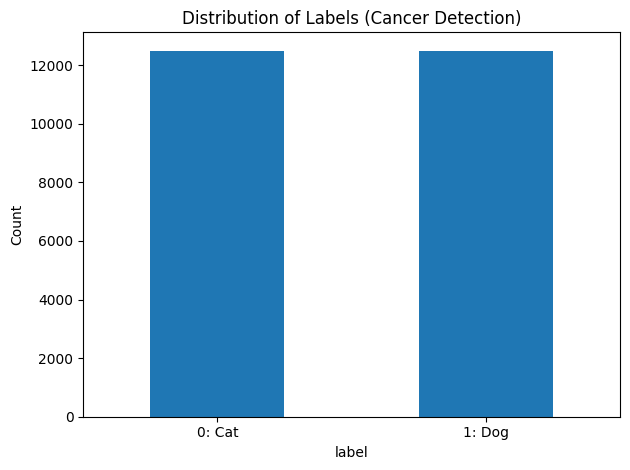

In [16]:
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Labels (Cancer Detection)')
plt.ylabel('Count')
plt.xticks([0, 1], ["0: Cat", "1: Dog"], rotation=0)  
plt.tight_layout()
plt.show()

### Train-validation split the data set

80% of the data will be used for training while the remaining 20% will be used for validation

# Data preprocessing and augmentation for training

Convert label to string for easier processing

Normalization: Normalize pixel values by subtracting the mean and dividing by the standard deviation for each channel to standardize the input.

Data Augmentation: Apply techniques such as flipping, and slight zooming to increase the diversity of training samples and improve model generalization.

Stratified Split: Use a stratified train-validation split to maintain class balance in both sets.

### Converting label data type

In [17]:
df['label'] = df['label'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  24998 non-null  object
 1   label     24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [18]:
# Train validation splitting
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 19998
Validation set size: 5000


### Check the training dataset

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19998 entries, 7097 to 15726
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  19998 non-null  object
 1   label     19998 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


### Preprocessing and augmentation for the training dataset

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalization
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=128,
    class_mode='binary',
    validate_filenames=False
)

Found 19998 non-validated image filenames belonging to 2 classes.


### Data augmentation setup for Validation Set

In [23]:
val_datagen = ImageDataGenerator(rescale=1./255) # just normalization

In [25]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=128,
    class_mode='binary',
    validate_filenames=False
)

Found 5000 non-validated image filenames belonging to 2 classes.


# Models

1. Basic CNN Model
2. Deeper more complex model

CNN approaches are appropriate for cat vs dog classification because they automatically learn hierarchical visual features crucial for image recognition. Their convolutional layers detect important patterns like edges, textures, and shapes at various scales while maintaining spatial relationships, and their shared weights and pooling operations provide robustness to variations in position, scale, and orientation - all essential for distinguishing between cats and dogs with their diverse appearances, poses, and backgrounds.

### Basic CNN Model

In [26]:
# Basic CNN model
def create_basic_cnn():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        # Flatten and dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and display the basic CNN model
basic_model = create_basic_cnn()
basic_model.summary()

/home/yuki/workspace/cat_dog/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745939927.443049   65694 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:08:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

# Hyperparameter 

In [27]:
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'{model_name}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
    
    return [checkpoint, early_stopping, reduce_lr]

In [28]:
basic_history = basic_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 128,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 128,
    callbacks=get_callbacks('basic_cnn'),
    verbose=1
)

/home/yuki/workspace/cat_dog/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1745939941.390847   66479 service.cc:152] XLA service 0x7fc7f8004880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745939941.390888   66479 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-29 08:19:01.418729: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745939941.625485   66479 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/156 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5176 - loss: 0.7014 

I0000 00:00:1745939946.669239   66479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 80/156 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.5446 - loss: 0.6933

/home/yuki/workspace/cat_dog/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5700 - loss: 0.6775
Epoch 1: val_accuracy improved from -inf to 0.69812, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 359ms/step - accuracy: 0.5703 - loss: 0.6773 - val_accuracy: 0.6981 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 2/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.6797 - loss: 0.6250

/home/yuki/workspace/cat_dog/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.69812 to 0.70353, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6797 - loss: 0.6250 - val_accuracy: 0.7035 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7024 - loss: 0.5731
Epoch 3: val_accuracy improved from 0.70353 to 0.74479, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 52s 330ms/step - accuracy: 0.7024 - loss: 0.5731 - val_accuracy: 0.7448 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 4/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.7188 - loss: 0.5392
Epoch 4: val_accuracy did not improve from 0.74479
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7188 - loss: 0.5392 - val_accuracy: 0.7422 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7330 - loss: 0.5347
Epoch 5: val_accuracy improved from 0.74479 to 0.76222, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 50s 321ms/step - accuracy: 0.7330 - loss: 0.5347 - val_accuracy: 0.7622 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 6/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.6875 - loss: 0.5574
Epoch 6: val_accuracy improved from 0.76222 to 0.76402, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6875 - loss: 0.5574 - val_accuracy: 0.7640 - val_loss: 0.4920 - learning_rate: 0.0010
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7536 - loss: 0.5105
Epoch 7: val_accuracy improved from 0.76402 to 0.78065, saving model to basic_cnn_best_model.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 329ms/step - accuracy: 0.7536 - loss: 0.5104 - val_accuracy: 0.7806 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 8/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.8359 - loss: 0.4281
Epoch 8: val_accuracy did not improve from 0.78065
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8359 - loss: 0.4281 - val_accuracy: 0.7798 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7588 - loss: 0.4954
Epoch 9: val_accuracy did not improve from 0.78065
156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 328ms/step - accuracy: 0.7589 - loss: 0.4953 - val_accuracy: 0.7758 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 10/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.7891 - loss: 0.4301
Epoch 10: val_accuracy did not improve from 0.78065
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7891 - loss: 0.4301 - val_accuracy: 0.7688 - val_loss: 0.4775 - learning_rate: 0.0010
Restori

### Deeper More Complex Model

In [38]:
def create_vgg_style_cnn():
    model = Sequential([
        # First block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        # Second block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        # Third block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        # # Fourth block
        # Conv2D(256, (3, 3), activation='relu', padding='same'),
        # Conv2D(256, (3, 3), activation='relu', padding='same'),
        # MaxPooling2D(2, 2),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

vgg_model = create_vgg_style_cnn()

In [39]:
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 64,
    callbacks=get_callbacks('vgg_cnn'),
    verbose=1
)

Epoch 1/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.5368 - loss: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.64100, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - accuracy: 0.5557 - loss: 0.6758 - val_accuracy: 0.6410 - val_loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 2/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 47s 306ms/step - accuracy: 0.6599 - loss: 0.6174
Epoch 2: val_accuracy improved from 0.64100 to 0.71940, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.6640 - loss: 0.6122 - val_accuracy: 0.7194 - val_loss: 0.5492 - learning_rate: 1.0000e-04
Epoch 3/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 47s 304ms/step - accuracy: 0.6970 - loss: 0.5764
Epoch 3: val_accuracy did not improve from 0.71940
312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - accuracy: 0.7023 - loss: 0.5703 - val_accuracy: 0.7046 - val_loss: 0.5680 - learning_rate: 1.0000e-04
Epoch 4/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 49s 321ms/step - accuracy: 0.7241 - loss: 0.5446
Epoch 4: val_accuracy did not improve from 0.71940
312/312 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.7283 - loss: 0.5399 - val_accuracy: 0.6990 - val_loss: 0.5764 - learning_rate: 1.0000e-04
Epoch 5/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.7393 - loss: 0.5322
Epoch 5: val_accuracy improved from 0.71940 to 0.76140, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.7439 - loss: 0.5254 - val_accuracy: 0.7614 - val_loss: 0.4953 - learning_rate: 1.0000e-04
Epoch 6/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.7533 - loss: 0.5073
Epoch 6: val_accuracy did not improve from 0.76140
312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - accuracy: 0.7543 - loss: 0.5045 - val_accuracy: 0.7274 - val_loss: 0.5461 - learning_rate: 1.0000e-04
Epoch 7/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.7712 - loss: 0.4848
Epoch 7: val_accuracy improved from 0.76140 to 0.76800, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.7713 - loss: 0.4828 - val_accuracy: 0.7680 - val_loss: 0.4888 - learning_rate: 1.0000e-04
Epoch 8/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 48s 315ms/step - accuracy: 0.7657 - loss: 0.4879
Epoch 8: val_accuracy improved from 0.76800 to 0.78140, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.7704 - loss: 0.4800 - val_accuracy: 0.7814 - val_loss: 0.4745 - learning_rate: 1.0000e-04
Epoch 9/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 47s 307ms/step - accuracy: 0.7837 - loss: 0.4677
Epoch 9: val_accuracy did not improve from 0.78140
312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.7845 - loss: 0.4648 - val_accuracy: 0.7808 - val_loss: 0.4768 - learning_rate: 1.0000e-04
Epoch 10/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 47s 308ms/step - accuracy: 0.7883 - loss: 0.4517
Epoch 10: val_accuracy improved from 0.78140 to 0.79240, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.7897 - loss: 0.4502 - val_accuracy: 0.7924 - val_loss: 0.4493 - learning_rate: 1.0000e-04
Epoch 11/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 49s 316ms/step - accuracy: 0.7990 - loss: 0.4377
Epoch 11: val_accuracy improved from 0.79240 to 0.80100, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.7986 - loss: 0.4391 - val_accuracy: 0.8010 - val_loss: 0.4367 - learning_rate: 1.0000e-04
Epoch 12/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.8075 - loss: 0.4241
Epoch 12: val_accuracy improved from 0.80100 to 0.80360, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.8071 - loss: 0.4259 - val_accuracy: 0.8036 - val_loss: 0.4275 - learning_rate: 1.0000e-04
Epoch 13/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 47s 307ms/step - accuracy: 0.8043 - loss: 0.4188
Epoch 13: val_accuracy did not improve from 0.80360
312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.8053 - loss: 0.4206 - val_accuracy: 0.7990 - val_loss: 0.4466 - learning_rate: 1.0000e-04
Epoch 14/15
154/312 ━━━━━━━━━━━━━━━━━━━━ 47s 299ms/step - accuracy: 0.8057 - loss: 0.4205
Epoch 14: val_accuracy improved from 0.80360 to 0.81920, saving model to vgg_cnn_best_model.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - accuracy: 0.8050 - loss: 0.4207 - val_accuracy: 0.8192 - val_loss: 0.4016 - learning_rate: 1.0000e-04
Epoch 15/15
157/312 ━━━━━━━━━━━━━━━━━━━━ 49s 318ms/step - accuracy: 0.8126 - loss: 0.4100
Epoch 15: val_accuracy did not improve from 0.81920
312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8156 - loss: 0.4063 - val_accuracy: 0.8164 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 14.


As expected the deeper model using vgg takes much longer to train compared to the basic CNN. This is because of the additional layers in the model, making the computational complexity significantly higher. However, this also allows the model to learn on more complex and fine details within the image. Therefore, increasing the performance of the model compared to the basic CNN

# 

# Result and Analysis

### Overview

Key Findings:

- The VGG-style CNN achieved higher validation accuracy (approximately 81%) compared to the Basic CNN (approximately 78%)
- Data augmentation successfully prevented overfitting in both models
- Early stopping typically triggered before completing all 15 epochs, showing efficient training
- Both models successfully learned distinctive features to separate cats from dogs
- The deeper architecture of the VGG-style CNN proved more effective at this image classification task

### Plots

Basic CNN Training History:


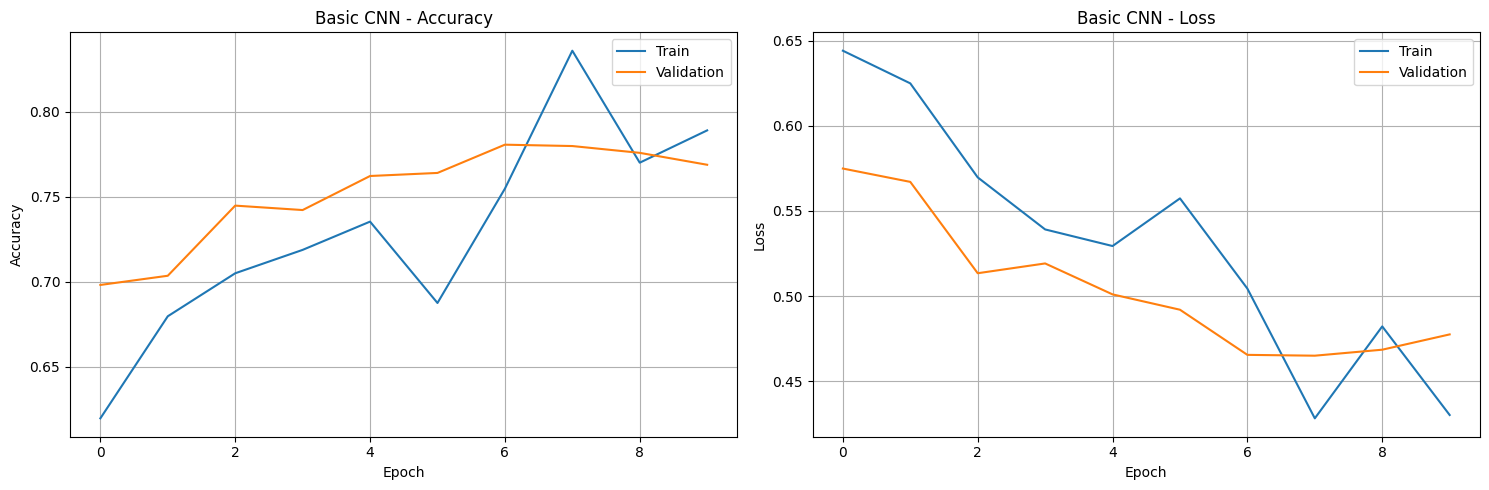

VGG-style CNN Training History:


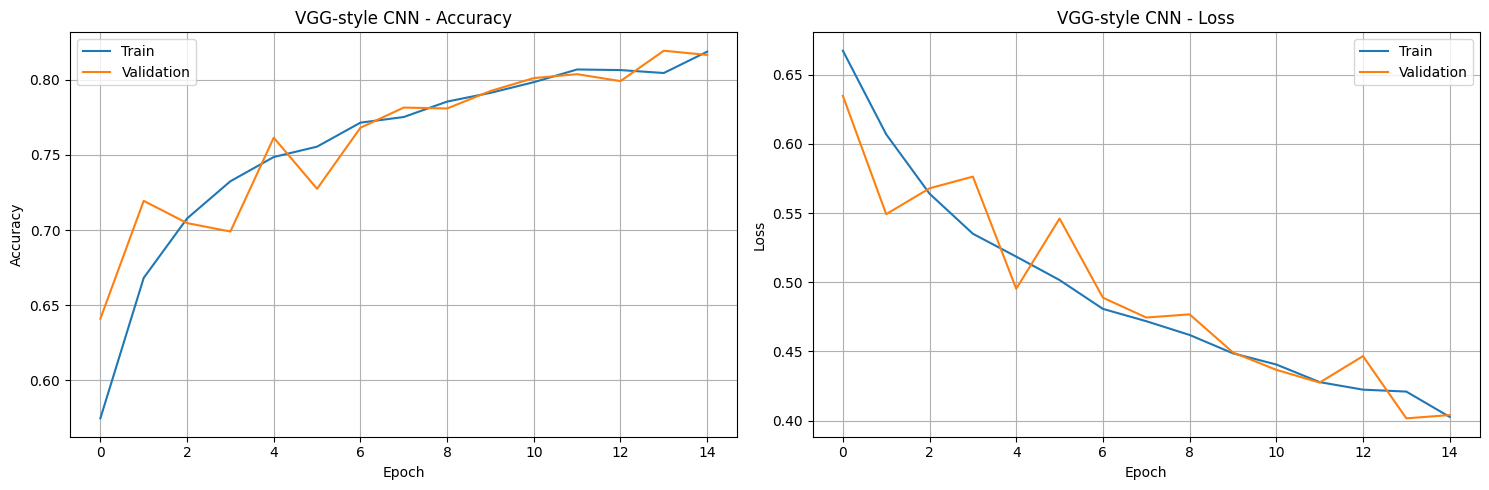

In [40]:
# Plot training history
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history for all models
print("Basic CNN Training History:")
plot_history(basic_history, 'Basic CNN')

print("VGG-style CNN Training History:")
plot_history(vgg_history, 'VGG-style CNN')

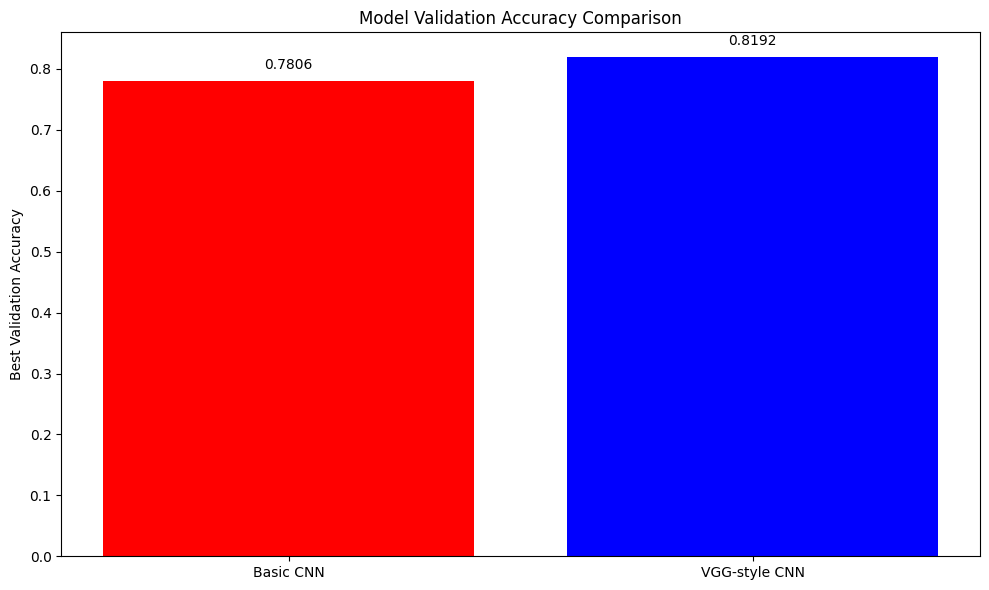

In [41]:
models = ['Basic CNN', 'VGG-style CNN']
val_accuracies = [
    max(basic_history.history['val_accuracy']),
    max(vgg_history.history['val_accuracy'])
]

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(models, val_accuracies, color=['red', 'blue'])
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Best Validation Accuracy')
for i, acc in enumerate(val_accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Conclusion

Learning and Takeaways:
VGG-style model, significantly enhances the network's ability to learn hierarchical representations of visual features crucial for distinguishing between cats and dogs. While computational complexity increases, the performacne substantionally increases as the depth of the network is increased. 

Why Some Approaches Didn't Work:
The simpler Basic CNN model, despite being more computationally efficient, struggled to achieve the same level of accuracy as the VGG-style model because it lacked sufficient depth to capture the complex visual patterns necessary for robust classification.

Ways to Improve:
Future improvements could include implementing transfer learning with pre-trained models like VGG16 or ResNet